In [65]:
import warnings
warnings.filterwarnings("ignore")

In [66]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score, auc
from sklearn.metrics import roc_auc_score

In [67]:
%matplotlib inline
plt.style.use('bmh')
sns.set_theme(style="whitegrid")

In [68]:
# pyspark packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, sum, desc, split, length, initcap, trim, lower, count, when)
from pyspark.sql.types import (
    StructType, StructField, IntegerType, StringType,
    FloatType, BooleanType, DateType, DoubleType)

In [69]:
spark = SparkSession.builder \
    .appName("Clustering") \
    .getOrCreate()

spark

In [70]:
ip_data = spark.read.option("header", "True") \
                .option("inferSchema", "True") \
                .option("quote", '"') \
                .option("escape", '"') \
                .option("sep", ",") \
                .option("ignoreLeadingWhiteSpace", "True") \
                .option("ignoreTrailingWhiteSpace", "True") \
                .option("multiLine", "True") \
                .option("mode", "PERMISSIVE") \
                .csv("../data/gun_violence_cleaned_data_2013_2018.csv")

print(f"Number of records in the data : {ip_data.count()}")
print(f"Number of columns: {len(ip_data.columns)}")

Number of records in the data : 239677
Number of columns: 45


In [71]:
txt_columns = ["notes"]

ip_data = ip_data.fillna("missing", subset=txt_columns)

In [72]:
pandas_ip_df = ip_data.toPandas()

### Clustering Using KMeans

- Identify clusters with high fatalities or injuries.
- Recognize patterns in gun types or participant demographics.
- Pinpoint clusters associated with specific states or regions.

In [74]:
features = [
    'n_killed', 'n_injured', 'gun_stolen_not_stolen_freq', 'gun_stolen_stolen_freq',
    'gun_type_handgun_freq', 'gun_type_rifle_freq', 'participant_gender_female_freq',
    'participant_gender_male_freq', 'participant_status_killed_freq'
]

X = pandas_ip_df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

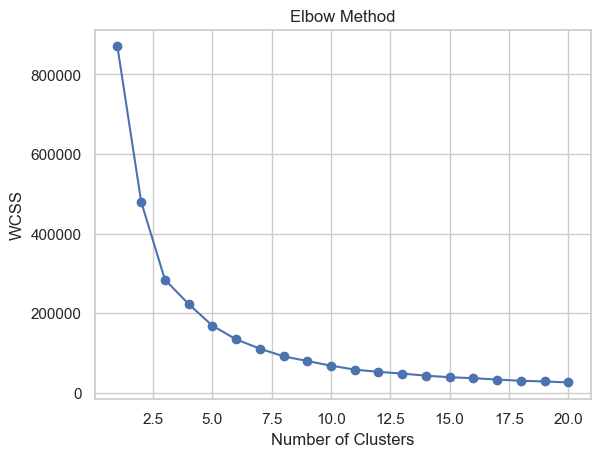

In [75]:
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 21), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [94]:
optimal_clusters = 8
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(X_pca)

pandas_ip_df['cluster'] = clusters

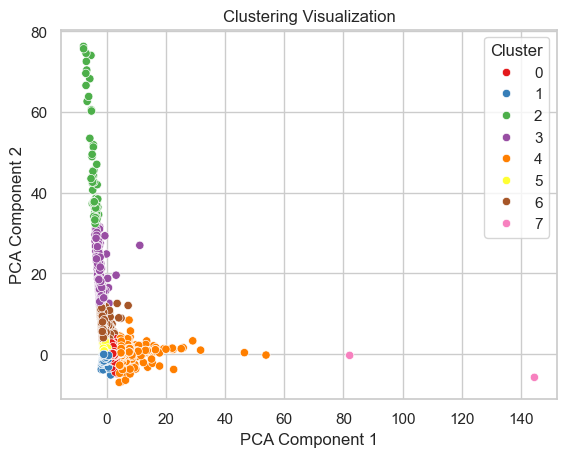

In [96]:
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='Set1')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clustering Visualization')
plt.legend(title='Cluster')
plt.show()

In [97]:
cluster_summary = pandas_ip_df.groupby('cluster')[features].mean()

In [98]:
print(cluster_summary)

          n_killed  n_injured  gun_stolen_not_stolen_freq  \
cluster                                                     
0         0.987828   0.219254                    0.003513   
1         0.000006   0.623005                    0.000116   
2         0.000000   0.031250                    0.421875   
3         0.014388   0.000000                    0.305755   
4         2.196082   0.356829                    0.007689   
5         0.000000   0.187731                    0.066125   
6         0.017129   0.035073                    0.095432   
7        38.500000  36.500000                    1.000000   

         gun_stolen_stolen_freq  gun_type_handgun_freq  gun_type_rifle_freq  \
cluster                                                                       
0                      0.005473               0.048585             0.008046   
1                      0.001628               0.002467             0.000043   
2                     22.000000              24.687500             6.1718